### About this notebook
Этот ноутбук создан для реализации собственного проекта.

**Суть проекта - распознавать движение руки в виде трясущейся буквы L.** Данный проект был придуман и реализован для применения методов компьютерного зрения и ознакомления с **STGCN (spatial-temporal graph convolutional network)**. Сам результат не несет практической пользы. Распозновать трясущуюся букву L было выбрано целью _из-за простоты создания набора данных_ (он был создан вручную) и _просто ради забавы_.

#### Компоненты проекта и используемый пайплайн

В проекте используется следующий пайплайн:

1. mediapipe (модель для распознавания графа руки) достает нормализованные координаты
2. полученные точки сохраняются в буфер _длиною в 30 кадров_
3. каждые _5 кадров_ буфер отправляется на инференс в обученный STGCN.

В данном проекте есть следующие файлы отвечающие каждый за свое:

- **camera.py** - файл для записи датасета
- **STGCN.py** - файл с реализацией STGCN
- **main.ipynb** - этот ноутбук для обучения и оценки модели
- **model_inference.py** - файл для инференса модели
- **.pth файлы** - сохраненные модели и их результаты
- **nums.txt** - файл для сбора датасета

#### Сбор датасета

Перед нами стоит задача бинарной классификации. Обозначим классом 0 - класс, где нету нужного движения, а классом 1 - где есть нужное движение. 

Для сбора набора данных использовался файл camera.py. На букву q привязана запись положительного класса, на e - отрицательного. О начале, конце и затраченном времени (оно должно быть около 1 секунды) оповещается в консоли. Затраченное время выводится для того, чтобы отслеживать провисания - если устройство, с которого ведется запись набора данных, не может обрабатывать 30 кадров в секунду - то время записи будет дольше, а такие примеры в датасете будут неподходящими.

Количество примеров отслеживается в nums.txt. Неправильные примеры (их было мало, человеческий фактор - когда нажималась кнопка одного класса, а показывался другой) можно удалять вручную (хоть и будут пробелы в нумерации - это не помешает инициализации датасета - будут выбраны все файлы из папки dataset). **В данной работе не удалялись неправильные примеры в связи с их малым количеством.**

#### Обработка данных, обучение и оценка модели

Обработка данных, обучение и оценка модели будет расписана ниже к каждой ячейке кода. 

В ячейке ниже импортируем нужные нам модули

In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import mediapipe as mp
from IPython.display import HTML
import ipywidgets as widgets
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from STGCN import SpatialTemporalGraphConvNetwork
from tqdm import tqdm

### Dataset

Следующая ячейка _ответственна за реализацию_ двух классов: **MyDataset** и **MySubset**.

Напомню, что датасет состоит из выходов mediapipe - координат графа руки на протяжении 30 кадров. То есть наши сэмплы это массивы размерностью **NxTxC** где **N = 21**, количество точек графа (21 потому что распознается только 1 рука), **T = 30** кадров (30 из-за того, что камера 720p30, то есть движение распознается на участке в 1 секунду = в 30 кадров), **C = 3** количество координат - (x, y, z).

Класс **MyDataset** в методе init собирает все примеры из папки dataset и **хранит их в self.data парами вида (пример, метка класса)**.

Класс **MySubset** написан для разделения исходного датасета на _обучающую_, _валидационную_ и _тренировочную_ выборку. На валидационной и тренировочной нам стоит убрать augment_prob - вероятность аугментации (чтобы оценки не отличались при каждом запуске).

**В виде аугментации используется flip** (1 - x). Точки в графе нормализованы по размеру изображения и координаты x и y находятся в диапозоне от 0 до 1. Следовательно, если мы заменим у графа все x на 1 - x, то рука как бы отразится, за счет чего мы можем получить больше обучающих примеров.

Также немаловажную роль играет **нормализация примеров** - будем вычитать из координат каждой точки графа координату запястья. Это нормализует наши примеры и **уберет смещение по кадру**. Дополнительно нормализуем и по размеру ладони - чтобы **примеры не зависили от того, близко находится ладонь или далеко.**

In [2]:
class MyDataset(Dataset):
    def __init__(self, root_dir, augment_prob=0.5):
        self.augment_prob = augment_prob
        
        self.data = []
        for i in range(len(os.listdir(root_dir))):
            path = os.path.join(root_dir, "class_" + str(i))
            class_data = os.listdir(path)
            for sample_path in class_data:
                sample_full_path = os.path.join(path, sample_path)
                sample = np.load(sample_full_path)
                self.data.append((sample, i))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample, label = self.data[index]
        
        if np.random.rand() < self.augment_prob:
            sample = self.augmentation_flip(sample)

        sample = self.normalize(sample)
        # [T, N, C] -> [C, T, N]
        sample = np.transpose(sample, (2, 0, 1))
        sample = torch.from_numpy(sample)
        y = torch.tensor(label, dtype=torch.long)

        return sample, y

    @staticmethod
    def normalize(sample):
        wrist = sample[:, 0, :]
        sample = sample - wrist[:, np.newaxis, :]

        ref_point = sample[:, 9, :]
        scale = np.linalg.norm(ref_point - wrist)

        if scale > 0:
            sample = sample / scale

        return sample
        
    @staticmethod
    def augmentation_flip(sample):
        # sample shape is [T, N, C]
        sample[:, :, 0] = 1 - sample[:, :, 0]
        return sample


class MySubset(MyDataset):
    def __init__(self, augment_prob=0.5, zero_frames_prob=0.0):
        self.data = []
        self.indicies = []
        self.augment_prob = augment_prob
        self.zero_frames_prob = zero_frames_prob
    
    def add_samples(self, data, indicies):
        for index in indicies:
            self.data.append(data[index])
            self.indicies.append(index)

В ячейке ниже разделим наш датасет на _трейн_, _валидацию_ и _тест_ и **инциализируем dataloader'ы** для последующего применения наших сабсетов.

Также выведем количество примеров в каждой выборке (не забываем, что с аугментацией **в train по факту в 2 раза больше примеров**) и используемый device (где будем обучать нашу модель - на видеокарте или на процессоре).

In [3]:
def sep_data(dataset, batch_size, split_ratio=[0.8, 0.1, 0.1]):
    if sum(split_ratio) > 1:
        return f'sum of ratio should be 1 or lower'
    
    train_data, val_data, test_data = MySubset(), MySubset(), MySubset()
    num_samples = len(dataset)
    train_num_samples = int(split_ratio[0] * num_samples)
    val_num_samples = int(split_ratio[1] * num_samples)
    test_num_samples = int((1 - sum(split_ratio)) * num_samples) if len(split_ratio) == 2 else int(split_ratio[2] * num_samples)

    indicies = np.arange(len(dataset))
    np.random.shuffle(indicies)
    train_data.add_samples(dataset.data, indicies[:train_num_samples])
    val_data.add_samples(dataset.data, indicies[train_num_samples:(train_num_samples + val_num_samples)])
    test_data.add_samples(dataset.data, indicies[(train_num_samples + val_num_samples):])

    val_data.augment_prob = 0
    test_data.augment_prob = 0 

    lens = {'train_data': len(train_data),
           'val_data': len(val_data),
           'test_data': len(test_data)}
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

    return train_dataloader, val_dataloader, test_dataloader, lens

np.random.seed(42)
dataset = MyDataset(root_dir="dataset")
batch_size = 20
device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader, val_dataloader, test_dataloader, lens = sep_data(dataset, batch_size)

print(f'Train samples: {lens['train_data'] - lens['train_data'] % batch_size}')
print(f'Val samples: {lens['val_data']}')
print(f'Test samples: {lens['test_data']}')
print(f'Device: {device}')

Train samples: 600
Val samples: 76
Test samples: 78
Device: cuda


### Обучение и оценка модели
Ниже реализуем стандартные функции для обучения нашей модели. С каждой эпохой будем сохранять результаты, чтобы посмотреть историю изменения Loss'a и accuracy.

В связи с тем, что у нас бинарная классификация и мы можем сдвигать порог уверенности, то accuracy не информативно на все 100%, так как пустая модель присваивает ту метку класса, у которой вероятность просто выше. Из-за этого позже мы будем смотреть на матрицу ошибок, ROC кривую и PR кривую для того, чтобы принять решение - стоит ли менять порог или нет.

In [4]:
def train_stgcn(model, loss_instance, data_loader, optimizer, epoch, epochs, verbose=True, device=device):
    model.to(device)
    model.train()
    total_loss = 0.0
    total_num = 0

    if verbose:
        data_bar = tqdm(data_loader)
    
    for data, label in data_bar:
        data, label = data.to(device), label.to(device)

        logits = model(data)

        optimizer.zero_grad()
        loss = loss_instance(logits, label)
        loss.backward()
        optimizer.step()

        batch_size = len(label)
        total_num += batch_size
        total_loss += loss.item() * batch_size

        if verbose:
            data_bar.set_description('Train Epoch: [{}/{}] Loss: {:.4f}'.format(epoch, epochs, total_loss / total_num))
    
    return total_loss / total_num

def eval_stgcn(model, data_loader, loss_instance=None, device=device):
    model.to(device)
    model.eval()
    results = {}
    true_predict = 0
    total_predict = 0
    total_loss = 0
    
    with torch.no_grad():
        for item in data_loader:
            data, label = item
            data, label = data.to(device), label.to(device)
            logits = model(data)

            if loss_instance is not None:
                loss = loss_instance(logits, label)
                total_loss = loss.item() * label.size(0)
            

            true_predict += (torch.argmax(logits, dim=1) == label).sum().item()
            total_predict += label.size(0)

        accuracy = true_predict / total_predict
        total_loss = total_loss / total_predict

    
    results['accuracy%'] = accuracy * 100
    results['logits'] = logits
    results['loss'] = total_loss
    
    return results

In [5]:
def train_model(model=None, loss_instance=None, optimizer=None, scheduler=None, train_dataloader=None, val_dataloader=None, epochs=25, save=False, save_file_name='default', verbose=True, device=device):
    results = {'loss_history': [],
    'train_acc_history':[],
    'val_acc_history': []}

    if not(model and loss_instance and optimizer and train_dataloader and val_dataloader):
        print(f'You should pass everything!')
        return None
    
    for epoch in range(epochs):
        train_loss = train_stgcn(model, loss_instance, train_dataloader, optimizer, epoch, epochs, verbose, device)
        train_results = eval_stgcn(model, train_dataloader, None, device)
        val_results = eval_stgcn(model, val_dataloader, loss_instance, device)
        results['loss_history'].append(train_loss)
        results['train_acc_history'].append(train_results['accuracy%'])
        results['val_acc_history'].append(val_results['accuracy%'])
        val_loss = val_results['loss']
        scheduler.step(val_loss)

        if save:
            torch.save({'model_params': model.state_dict(),
               'results': results}, save_file_name)

    return model, results

Инициализируем нашу модель, optimizer и scheduler. Последний нужен для уменьшения learning rate нашего optimizer'а.

Также выведем summary нашей модели - посмотрим на архитектуру нашей нейронной сети и увидим, сколько параметров имеет каждый слой.

In [6]:
model = SpatialTemporalGraphConvNetwork(2, 3, 21, 0.5, device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=2.5e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.9, patience=5, threshold=1e-2, min_lr=1e-5)
loss_instance = CrossEntropyLoss()

print(summary(model, input_size=(3, 30, 21)))

Layer (type:depth-idx)                   Param #
├─STGCNBlock: 1-1                        --
|    └─GraphConv: 2-1                    192
|    └─Conv2d: 2-2                       36,928
|    └─ReLU: 2-3                         --
|    └─BatchNorm2d: 2-4                  128
├─STGCNBlock: 1-2                        --
|    └─GraphConv: 2-5                    8,192
|    └─Conv2d: 2-6                       147,584
|    └─ReLU: 2-7                         --
|    └─BatchNorm2d: 2-8                  256
├─STGCNBlock: 1-3                        --
|    └─GraphConv: 2-9                    25,088
|    └─Conv2d: 2-10                      345,940
|    └─ReLU: 2-11                        --
|    └─BatchNorm2d: 2-12                 392
├─AdaptiveAvgPool2d: 1-4                 --
├─Linear: 1-5                            394
Total params: 565,094
Trainable params: 565,094
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─STGCNBlock: 1-1                        --
|    └─Graph

Следующие 3 ячейки - это основные ячейки для обучения, сохранения и загрузки нашей модели. 

Мы можем загрузить уже существующую baseline модель или обучить новую. Если была обучена новая - ниже можно сохранить ее в отдельный файл. Это создано для того, чтобы пробовать разные архитектуры, подходы в наборе данных и различные гиперпараметры (lr, weight_decay, batch_size и другие).

In [7]:
epochs = 250

loss_history = []
train_acc_history = []
save = 1

if 'baseline.pth' in os.listdir():
    try:
        answr = int(input(f'wanna create new baseline model?\n0 - No\n1 - Yes\n'))
    except ValueError:
        answr = 0

if answr:
    try:
        save = int(input(f'wanna save new baseline model?\n0 - No\n1 - Yes\n'))
    except ValueError:
        save = 0
    
    model, results = train_model(model=model,
                loss_instance=loss_instance,
                optimizer=optimizer,
                scheduler=scheduler,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                epochs=epochs,
                save=save,
                save_file_name='baseline.pth',
                verbose=True,
                device=device)

wanna create new baseline model?
0 - No
1 - Yes
 


In [8]:
if answr == 1:
    try:
        save = int(input(f'wanna save new model as inference model?\n0 - No\n1 - Yes\n'))
    except ValueError:
        save = 0
    
    if save == 1:
        try:
            model_file_name = input(f'File name for inference model? (model_for_inference.pth): ')
        except ValueError:
            model_file_name = 'model_for_inference.pth'
    
        if model_file_name[-4:] != '.pth':
            model_file_name += '.pth'
        
        torch.save({'model_params': model.state_dict(),
                       'results': results}, model_file_name)

In [9]:
try:
    cnt = 0
    dict_of_models = {}
    print(f'which model you wanna load? Enter number (default baseline.pth)')
    for i, item in enumerate(os.listdir()):
        if item[-4:] == '.pth':
            cnt += 1
            dict_of_models[cnt] = item
            print(f'{cnt}. {item}')
    
    answr1 = int(input())
    model_dict = torch.load(dict_of_models[answr1], map_location='cpu', weights_only=False)
    model.load_state_dict(model_dict['model_params'])
    results = model_dict['results']
except ValueError:
    baseline_dict = torch.load('baseline.pth', map_location='cpu', weights_only=False)
    model.load_state_dict(baseline_dict['model_params'])
    results = baseline_dict['results']

loss_history, train_acc_history, val_acc_history = results['loss_history'], results['train_acc_history'], results['val_acc_history']

which model you wanna load? Enter number (default baseline.pth)
1. baseline.pth
2. model_for_inference.pth


 2


#### Оценка модели
Как и упоминалось ранее, выведем следующие графики:
- историю loss'a
- историю accuracy (причем на train'е и на валидационной выборке)
- выведем матрицу ошибок
- roc и pr кривую на тестовом наборе данных (тот, который модель вообще не видела).

На roc кривой поставим точки с значениями порогов, чтобы визуально подобрать подходящий.

In [10]:
print(f'accuracies:\n')
print(f'accuracy on val dataset: {eval_stgcn(model, val_dataloader, None, device)['accuracy%']:.0f}%')
print(f'accuracy on train dataset: {eval_stgcn(model, train_dataloader, None, device)['accuracy%']:.0f}%')

accuracies:

accuracy on val dataset: 83%
accuracy on train dataset: 85%


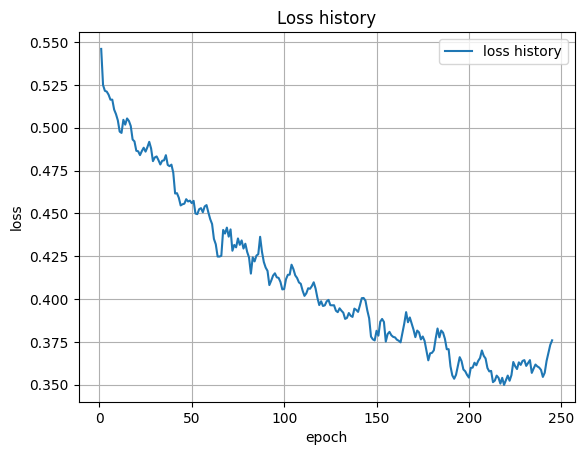

In [11]:
def plot_history(plot_title, ylabel, xlabel, arg_dict):
    for key, value in arg_dict.items():
        new_value = [sum(value[i:i + 5]) / 5 for i in range(len(value) - 5)] # using sliding window with stride 5
        plt.plot(np.arange(1, epochs - 4), new_value, label=key)
    plt.title(plot_title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.grid()
    plt.show()

arg_dict = {'loss history': loss_history}
plot_history('Loss history', 'loss', 'epoch', arg_dict)

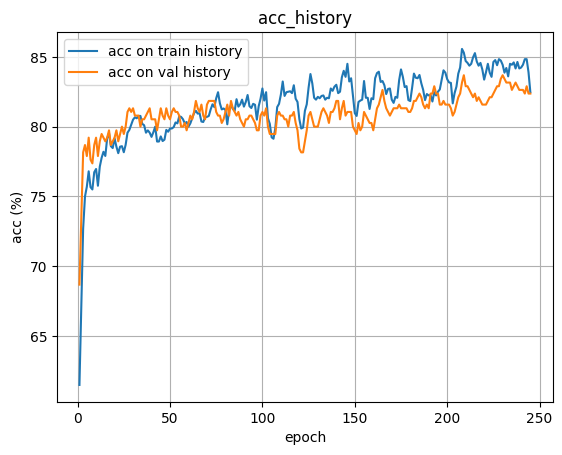

In [12]:
arg_dict = {'acc on train history': train_acc_history,
            'acc on val history': val_acc_history}

plot_history('acc_history', 'acc (%)', 'epoch', arg_dict)

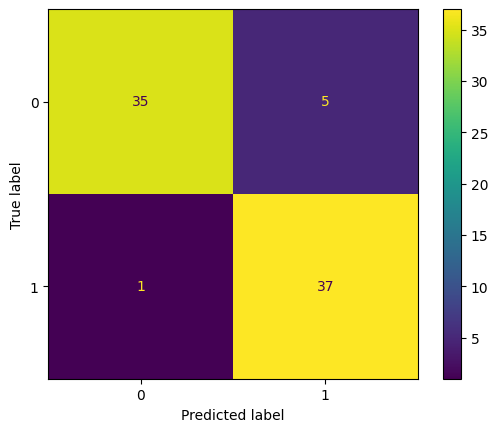

In [13]:
def print_confusion_matrix(model, test_dataloader):
    model = model.eval()
    y_pred_ = []
    label_ = []
    data_ = []
    
    with torch.no_grad():
        for item in test_dataloader:
            data, label = item
            data, label = data.to(device), label.to(device)
            y_pred_ += list(torch.argmax(model(data), dim=1).cpu())
            label_ += list(label.cpu())
            data_ += list(data.cpu())

    y_pred_ = np.array(y_pred_)
    label_ = np.array(label_)
    data_ = np.array(data_)
    
    data_fn = data_[(y_pred_ == 0) & (label_ == 1)]
    data_fp = data_[(y_pred_ == 1) & (label_ == 0)]
    
    cm = confusion_matrix(label_, y_pred_)
    ConfusionMatrixDisplay(cm).plot()
    
    return data_fn, data_fp

data_fn, data_fp = print_confusion_matrix(model, test_dataloader)

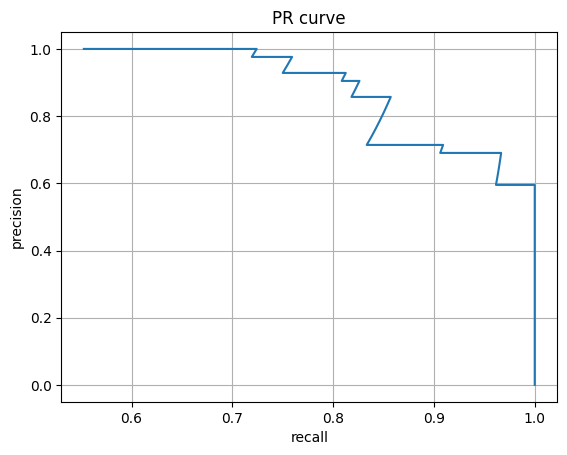

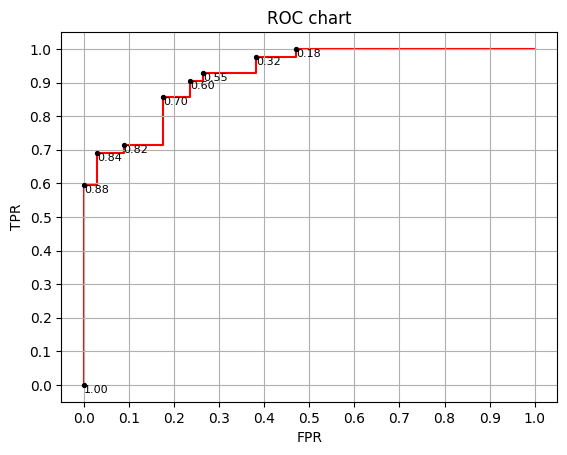

In [14]:
def get_metrics(model, dataloader, device=device):
    model.to(device)
    
    y_real = []
    y_prob = []
    metrics = {}
    with torch.no_grad():
        for data, y in dataloader:
            data, y = data.to(device), y.to(device)
            logits = model(data)
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(logits)
            y_real += list(y.cpu())
            y_prob += list(probs[:, 1].cpu())

    metrics['precision_recall_curve'] = precision_recall_curve(y_real, y_prob)
    metrics['roc_curve'] = roc_curve(y_real, y_prob)
    
    return metrics

metrics = get_metrics(model, val_dataloader)

precision_history, recall_history, tresholds = metrics['precision_recall_curve']
FPR, TPR, thresholds_ = metrics['roc_curve']

plt.plot(precision_history, recall_history)
plt.title('PR curve')
plt.ylabel('precision')
plt.xlabel('recall')
plt.grid()
plt.show()


n_points = len(thresholds_)
step = max(n_points // 8, 1)

for i in range(0, n_points, step):
    threshold = thresholds_[i]
    if i == 0:
        threshold = 1
    x = FPR[i]
    y = TPR[i]
    plt.text(x, y, f'{threshold:.2f}', fontsize=8, ha='left', va='top', alpha=1, color='black', zorder=2)
    plt.scatter(x, y, s=8, c='black', zorder=2)

plt.plot(FPR, TPR, color='red', zorder=1)
plt.title(f'ROC chart')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid()

#### Визаулиация ошибок
Следующая скрытая ячейка визуализирует примеры FP и FN на выбор. К сожалению, не везде работает маленький UI (кнопки и окошко для ввода номера примера), но оставим эту ячейку.

Вот пример, как должен выглядить выход ячейки если все сработало верно:

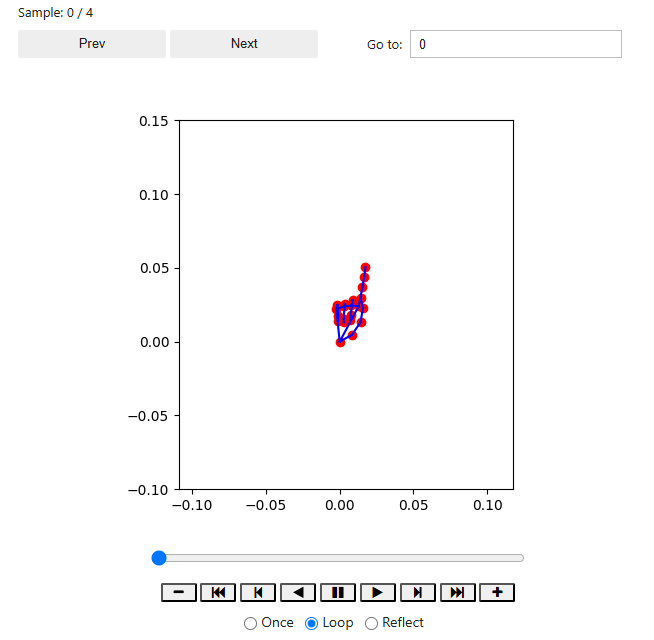

In [15]:
HAND_CONNECTIONS = mp.solutions.hands.HAND_CONNECTIONS
current_idx = 0
    
output = widgets.Output()
label = widgets.Label()

def create_anim(data, n):
    fig, ax = plt.subplots()
    hand_pic = ax.scatter(data[n, 0, 0, :], -1 * data[n, 1, 0, :], c='red')
    
    ax.set_xlim(np.min(data[n, 0, :, :]) - 0.1, np.max(data[n, 0, :, :]) + 0.1)
    ax.set_ylim(np.min(-1 * data[n, 1, :, :]) - 0.1, np.max(-1 * data[n, 1, :, :]) + 0.1)
    ax.set_aspect('equal')
    
    lines = []
    for (start, end) in HAND_CONNECTIONS:
        line, = ax.plot(
            [data[n, 0, 0, start], data[n, 0, 0, end]],
            [-1 * data[n, 1, 0, start], -1 * data[n, 1, 0, end]],
            c='blue'
        )
        lines.append(line)
    
    
    def update(i):
        coords = np.stack([data[n, 0, i, :], -1 * data[n, 1, i, :]], axis=-1)
        hand_pic.set_offsets(coords)
    
        for line, (start, end) in zip(lines, HAND_CONNECTIONS):
            xdata = [data[n, 0, i, start], data[n, 0, i, end]]
            ydata = [-1 * data[n, 1, i, start], -1 * data[n, 1, i, end]]
            line.set_data(xdata, ydata)
            
        return [hand_pic, *lines] 
    
    ani = animation.FuncAnimation(fig, update, interval=100, frames=data.shape[2])
    plt.close(fig)

    with output:
        output.clear_output(wait=True)
        display(HTML(ani.to_jshtml()))

    label.value = f"Sample: {n} / {data.shape[0]-1}"
    jump_box.value = n

def on_prev_clicked(data, b):
    global current_idx
    current_idx = (current_idx - 1) % data.shape[0]
    create_anim(data, current_idx)

def on_next_clicked(data, b):
    global current_idx
    current_idx = (current_idx + 1) % data.shape[0]
    create_anim(data, current_idx)

def on_jump_change(data, change):
    global current_idx
    if change['name'] == 'value' and isinstance(change['new'], int):
        idx = change['new']
        if 0 <= idx < data.shape[0]:
            current_idx = idx
            create_anim(data, current_idx)


n = int(input(f'Введите какие данные вы хотите посмотреть в анимации:\n0 - FP\n1 - FN\n'))

if n == 0:
    data = data_fp
elif n == 1:
    data = data_fn

prev_button = widgets.Button(description="Prev")
next_button = widgets.Button(description="Next")
jump_box = widgets.BoundedIntText(
    value=0, min=0, max=data.shape[0]-1, description="Go to:"
)

prev_button.on_click(lambda b: on_prev_clicked(data, b))
next_button.on_click(lambda b: on_next_clicked(data, b))
jump_box.observe(lambda change: on_jump_change(data, change), names='value')

buttons = widgets.HBox([prev_button, next_button, jump_box])
ui = widgets.VBox([label, buttons])
display(ui, output)

create_anim(data, current_idx)

Введите какие данные вы хотите посмотреть в анимации:
0 - FP
1 - FN
 1


Output()